# Description
Trian an ONN encoder with a 16-channel non-negative convolutional layer as the frontend, followed by 2 optical fully connected layers before the bottleneck layer.

# Load Libraries

In [80]:
from __future__ import print_function
import os, sys
import math
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
import optuna
import ray

import wandb
from torchvision import datasets, transforms
import torchvision

In [26]:
""" Training and hyperparameter search configurations """

parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=250, metavar='N',
                    help='number of epochs to train (default: 100)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--gpus', default=0,
                    help='gpus used for training - e.g 0,1,3')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--wandb', action='store_true', default=True, 
                    help='enables wandb logger')  
parser.add_argument('--csv', action='store_true', default=False, 
                    help='enables csv logger')  
args = parser.parse_args("")
args.cuda = not args.no_cuda and torch.cuda.is_available()

# Set random seeds to reproduce results
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Data loaders

In [6]:
""" Construct a dataset object from data. """

class EBI_Cell_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_import, label_import, data_transforms=None):
        self.physical_ground_truth = torch.tensor(data_import, dtype = torch.float32)
        self.labels = torch.tensor(label_import, dtype = torch.long)
        self.class_dict = {}
        self.transform = data_transforms
                
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        data = self.physical_ground_truth[idx]
        
        if self.transform:
             data = self.transform(self.physical_ground_truth[idx].unsqueeze(0))
            
        return data, self.labels[idx]

In [7]:
""" Prepare data loaders """
data = np.load('./EBI_Cells_grey_w_anomaly3.npz')
train_np = data['train_data_grey']
train_labels = data['train_labels']
val_np = data['val_data_grey']
val_labels = data['val_labels']
test_np = data['test_data_grey']
test_labels = data['test_labels']

transforms_digi = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                      transforms.Lambda(lambda x: x)])

transforms_digi_distort = transforms.Compose([transforms.RandomAffine(0, translate=(0.05, 0.05), scale=(0.96, 1.04)), \
                                              transforms.Lambda(lambda x: x.view(-1)), \
                                              transforms.Lambda(lambda x: x)])
kwargs = {}

""" input image loader w/. customerized samplers """
train_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(train_labels.shape[0])), \
                                              batch_size=args.batch_size, drop_last=False)
val_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(val_labels.shape[0])), \
                                              batch_size=args.test_batch_size, drop_last=False)
test_sampler = torch.utils.data.BatchSampler(\
                                             torch.utils.data.RandomSampler(range(test_labels.shape[0])), \
                                             batch_size=10000, drop_last=False)

train_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(train_np, train_labels, transforms_digi), 
    batch_sampler=train_sampler, **kwargs)

val_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(val_np, val_labels, transforms_digi), 
    batch_sampler=val_sampler, **kwargs)

test_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(test_np, test_labels, transforms_digi), 
    batch_sampler=test_sampler, **kwargs)

data_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(np.concatenate((test_np, val_np, train_np), axis=0), np.concatenate((test_labels, val_labels, train_labels), axis=0), transforms_digi), 
    batch_size=100000, shuffle=False, **kwargs)

# test_loader_phys = torch.utils.data.DataLoader( \
#     GT_Quickdraw_Dataset(test_np, test_labels, transforms_phys), \
#     batch_sampler=test_sampler, **kwargs)

# train_loader_phys_order = torch.utils.data.DataLoader( \
#     GT_Quickdraw_Dataset(train_np, train_labels, transforms_phys), \
#     batch_size=3000, shuffle=False, **kwargs)

# test_loader_phys = torch.utils.data.DataLoader( \
#     GT_Quickdraw_Dataset(test_np, test_labels, transforms_phys), \
#     batch_size=505, shuffle=False, **kwargs)

In [8]:
print(next(enumerate(data_loader))[1][0].shape)
print(next(enumerate(train_loader))[1][0].shape)
print(next(enumerate(val_loader))[1][0].shape)
print(next(enumerate(test_loader))[1][0].shape)

torch.Size([93050, 10000])
torch.Size([128, 10000])
torch.Size([1000, 10000])
torch.Size([9300, 10000])


# NN Models

In [9]:
class ONNLinear(nn.Module):
    def __init__(self, in_features, out_features, weight_noise=0.02, zeros_init=False):
        super(ONNLinear, self).__init__()
        self.W_Opt = \
            nn.Parameter(torch.randn(out_features, in_features, requires_grad = True) / math.sqrt(in_features)) \
            if not zeros_init else \
            nn.Parameter(torch.zeros(out_features, in_features, requires_grad = True)) 
        self.noise = weight_noise
        
    def forward(self, x):
        self.W_Opt.data = self.W_Opt.data.clamp_(0,1)
        out = F.linear(x + self.noise*torch.rand(x.shape, requires_grad=False, device=x.device), self.W_Opt)
        return out
    
class ONNConv(nn.Module):
    def __init__(self, ch_in, ch_out, weight_noise=0.02, zeros_init=False, **kwargs):
        super(ONNConv, self).__init__()
        self.conv2d = nn.Conv2d(ch_in, ch_out, **kwargs)
        if zeros_init:
            nn.init.zeros_(self.conv2d.weight)
        else: 
            nn.init.xavier_uniform(self.conv2d.weight)
        self.noise = weight_noise
        
    def forward(self, x):
        self.conv2d.weight.data = self.conv2d.weight.data.clamp_(0,1)
        out = self.conv2d(x + self.noise*torch.rand(x.shape, requires_grad=False, device=x.device))
        return out
    
def exp(Y, params):
    return torch.exp(-1.*torch.mul(Y, params))

def NL_func(Y, nonlinear_paramters):
    return torch.relu(torch.add(-1.*torch.mul(exp(Y, nonlinear_paramters[:, 1]), nonlinear_paramters[:, 0]) + \
                      -1.*torch.mul(exp(Y, nonlinear_paramters[:, 3]), nonlinear_paramters[:, 2]), \
                      nonlinear_paramters[:, 0]+nonlinear_paramters[:, 2])/50)

class ONNIntensifier(nn.Module):
    def __init__(self, func, coeffs):
        super(ONNIntensifier, self).__init__()
        self.func = func
        self.params = coeffs
        
    def forward(self, x):
        out = self.func(x, self.params)
        return out

In [10]:
coeffs = np.load('./Nonlinearity_Curves_April_8_data_refit.npz')['coeffs']

class digitalClassifier(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.fcs = nn.ModuleList([nn.Linear(i,j,**kwargs) for i, j in zip(Nunits[:-1], Nunits[1:])])

    def forward(self, X):
        X = X.view(X.size(0), -1)
        for i, fc in enumerate(self.fcs):
            X = fc(X)
            if fc is not self.fcs[-1]:
                X = F.relu(X)
        return X

class OpticalClassifier(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.narrow(torch.tensor(coeffs, dtype=torch.float32), 0, 32, 1), requires_grad = False)
        modules = []
        modules.append(ONNLinear(Nunits[0], Nunits[1], zeros_init=False)) 
        for l in range(1, len(Nunits)-1):
            modules.append(ONNIntensifier(NL_func, self.coeffs))
            modules.append(ONNLinear(Nunits[l], Nunits[l+1], zeros_init=False)) 
        self.encoder_nn = nn.Sequential(*modules)
        compressed_size = Nunits[-1]
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.encoder_nn(x)
        y = self.digifc(x)
        return y
    
class ConvClassifier(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.narrow(torch.tensor(coeffs, dtype=torch.float32), 0, 32, 1), requires_grad = False)
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.conv1 = ONNConv(1,16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.meanpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)
        self.flat = nn.Flatten()
        self.l1 = ONNLinear(25**2*16, Nunits[1], zeros_init=False)
        self.a1 = ONNIntensifier(NL_func, self.coeffs)
        compressed_size = Nunits[-1]
        self.l2 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
#         self.l4 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.conv1(x.reshape(-1, 1, 100, 100))
        x = self.bn1(x)
        x = self.relu(x)
        x = self.meanpool(x)
        x = self.flat(x)
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        y = self.digifc(x)
        return y

In [11]:
class ConvClassifier2(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.narrow(torch.tensor(coeffs, dtype=torch.float32), 0, 32, 1), requires_grad = False)
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.conv1 = ONNConv(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = ONNConv(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.meanpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)
        self.flat = nn.Flatten()
        self.l1 = ONNLinear(13**2*16, Nunits[1], zeros_init=False)
        self.a1 = ONNIntensifier(NL_func, self.coeffs)
        compressed_size = Nunits[-1]
        self.l2 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
#         self.l4 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.conv1(x.reshape(-1, 1, 100, 100))
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.meanpool(x)
        x = self.flat(x)
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        y = self.digifc(x)
        return y

In [12]:
class ConvClassifier3(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.narrow(torch.tensor(coeffs, dtype=torch.float32), 0, 32, 1), requires_grad = False)
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.conv1 = ONNConv(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
#         self.meanpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)
        self.conv2 = ONNConv(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
#         self.meanpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)
        self.flat = nn.Flatten()
        self.l1 = ONNLinear(13**2*16, Nunits[1], zeros_init=False)
        self.a1 = ONNIntensifier(NL_func, self.coeffs)
        compressed_size = Nunits[-1]
        self.l2 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
#         self.l4 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.conv1(x.reshape(-1, 1, 100, 100))
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.flat(x)
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        y = self.digifc(x)
        return y

In [13]:
class OracleClassifier(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, stride=1, padding=1, bias=False)
        self.backbone = torchvision.models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.flat = nn.Flatten()
        self.l1 = nn.Linear(512, Nunits[1])
        self.a1 = nn.ReLU(inplace=True)
        compressed_size = Nunits[-1]
        self.l2 = nn.Linear(Nunits[1], compressed_size)
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.conv1(x.reshape(-1, 1, 100, 100))
        x = self.backbone(x)
        x = self.flat(x)
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        y = self.digifc(x)
        return y

In [14]:
 """ helper functions and classes """
    
# A manager for dynamical book-keeping of the top k accuracies and model checkpoints during training
class top_k_manager(object):
    def __init__(self, k=10):
        self.k_best = k
        self.top_k_metric =[-1E10]*self.k_best
        self.top_k_paths = [""]*self.k_best
    
    # Compare the new_metric to the top k metrics in the past, and find its place.
    def update_rank(self, new_metric, path_keeping):
        for rank, record_metric in enumerate(self.top_k_metric):
            if record_metric <= new_metric:    
                if os.path.exists(self.top_k_paths[-1]):
                    os.remove(self.top_k_paths[-1])
                if rank < self.k_best - 1:
                    self.top_k_metric[rank+1:] = self.top_k_metric[rank:-1]
                    self.top_k_paths[rank+1:] = self.top_k_paths[rank:-1]  
                self.top_k_metric[rank] = new_metric
                self.top_k_paths[rank] = path_keeping
                return True # the top k list has been updated
        return False
    
# A simple hook class that returns the input and output of a layer during forward/backward pass
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

# Define training and testing functions


In [27]:
def train(epoch, model, optimizer, criterion, train_loader0):
    model.train()
    # Loop around mini-batches in an epoch
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader0):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        
        optimizer.step()
        
        pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        """
        if batch_idx % args.log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
            +f" ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
        """
        if args.wandb:
            wandb.log({"train_loss": loss.item(), "batch": batch_idx}, step = epoch)
            
    accuracy = 100.0 * correct/len(train_loader0.dataset)
    print(f"Train Epoch: {epoch} \t\tLoss: {loss.item():.6f}\tAccuracy: {accuracy: .2f}%")

def test(epoch, model, criterion, test_loader0):
    model.eval()
    test_loss = 0
    correct = 0
    hks = {"conv1":Hook(model.conv1), "bn1":Hook(model.bn1), "fc1":Hook(model.l1), "act1":Hook(model.a1), "fc2":Hook(model.l2)}
    # Loop around mini-batches in an epoch
    with torch.no_grad():
        for data, target in test_loader0:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            outputs = model(data)
            test_loss += criterion(outputs, target).item() # sum up batch loss
            pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader0)
    accuracy = 100. * correct / len(test_loader0.dataset)
    val_stats = {"val_loss": test_loss, "accuracy": accuracy}
    for k in hks.keys():
        val_stats[k] = wandb.Histogram(hks[k].output.cpu())      
    
    if epoch%1 == 0:
        print(f"\nTest set: Epoch {epoch}, Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader0.dataset)}" 
              +f"({accuracy:.0f}%)\n")

    if args.wandb:
        wandb.log(val_stats, step=epoch)
    return test_loss, accuracy

In [81]:
""" The objective function runs a trial in a NAS study (a loop around epochs) """

def objective(trial, NAS_project_name, gpu_id, train_loader0, test_loader0):

    # Define the hyperparameter search space
    batch_size = trial.suggest_categorical("batch_size", [128, 256])
    lr_factor0 = 2E-4
    lr_factor = trial.suggest_uniform("lrf", lr_factor0/4, lr_factor0*2)
    learning_rate = lr_factor * np.sqrt(batch_size/128)
    swa_lr = trial.suggest_uniform("swa_lr", 0.0002, 0.004)
    beta1 = trial.suggest_uniform("beta1", 0.99, 0.9999)
    beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)
    swa_start = trial.suggest_categorical("swa_start", [60, 80, 100])
    model_description = f"Conv1_ch16_200_20_b{batch_size}_AdamW_lr_{learning_rate:.6f}_betas_{beta1:.4f}_{beta2:.4f}_swa_{swa_start}_{swa_lr:.4f}" + f"_v_{trial.number}"

    # Instantiate a BNN model
    model = ConvClassifier([100**2, 200, 20])
    
    if args.cuda:
        torch.cuda.set_device(gpu_id)
        model.cuda() # transfer the model from cpu to gpu
    
    # Set up logging if necessary
    if args.wandb:
        wandb.init(project=NAS_project_name, name=model_description, reinit=True)
        wandb.watch(model, log="all")

    # Configure loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=0e-4)
    
    swa_model = AveragedModel(model)
    scheduler = CosineAnnealingLR(optimizer, T_max=swa_start+50)
    swa_scheduler = SWALR(optimizer, swa_lr=swa_lr)
    
    train_loader0.batch_sampler.batch_size = batch_size

    # Loop around epoches
    tpk_mngr = top_k_manager()
    ckpt_save_path = "./" + model_description
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
    for epoch in range(1, args.epochs + 1):
        train(epoch, model, optimizer, criterion, train_loader0)
        loss, accu = test(epoch, model, criterion, test_loader0)
        # schedule learning rate decay
        if epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()
        # Save the best models aftering the training gets more stable
        if epoch > 20:
            if tpk_mngr.update_rank(accu, ckpt_save_path+f"/ep{epoch}.pt"):
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, ckpt_save_path+f"/ep{epoch}.pt")

    # Log the best models
    trial.set_user_attr('top 3 accuracy', torch.tensor(tpk_mngr.top_k_metric[:3]).mean().item()) # Save the best accuracy during the taining loop      
    if args.wandb:
        wandb.run.summary["top_k_accu"] = tpk_mngr.top_k_metric
        wandb.run.summary["top_k_paths"] = tpk_mngr.top_k_paths
    return torch.tensor(tpk_mngr.top_k_metric[:5]).mean().item() # return the average of top k accuracies to guide NAS

In [82]:
""" Remote projects for NAS by running an optuna study on a thread """

@ray.remote(num_cpus=0.2, num_gpus=0.2)
class Parallel_NAS_project(object):
    def __init__(self, NAS_project_name, rseed, gpu_id):
        os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
        torch.cuda.set_device(gpu_id)
        self.sampler = optuna.samplers.TPESampler(seed=rseed) 
        self.storage = f'sqlite:///'+NAS_project_name+'.db' # way to specify an SQL database
        self.study = optuna.create_study(study_name=NAS_project_name, storage=self.storage, 
                                sampler=self.sampler, direction="maximize", load_if_exists=True)
    
    def runStudy(self, gpu_id, train_loader, test_loader):
        self.study.optimize(lambda trial: objective(trial, NAS_project_name, gpu_id, train_loader, test_loader), n_trials=18)

In [83]:
""" Create remote projects for NAS """

ray.init(num_gpus=4, ignore_reinit_error=True)
gpu_list = [0,0,0]
rseeds = [15,306,921]

NAS_project_name = "Jul_2_full_cell_convs1"
workerList = []
for (rseed, gpu_id) in zip(rseeds, gpu_list): 
    worker = Parallel_NAS_project.remote(NAS_project_name, rseed, gpu_id)
    workerList.append(worker)
    print(rseed, gpu_id) 

#train_loader_id = ray.put(train_loader) # important for large data loaders, since they would surpass memory limit if passed as parameters to study functions.
#test_loader_id = ray.put(test_loader)
remaining_ids = []
for i, w in enumerate(workerList):
    test_id = w.runStudy.remote(gpu_list[i], train_loader, val_loader)
    remaining_ids.append(test_id)

while remaining_ids:
    done_ids, remaining_ids = ray.wait(remaining_ids)
    result_id = done_ids[0]
    print(done_ids, remaining_ids)
    ray.get(result_id)
    
ray.shutdown()

15 0
306 0
921 0


(Parallel_NAS_project pid=48936) [I 2022-07-04 23:26:55,861] Using an existing study with name 'Jul_2_full_cell_convs1' instead of creating a new one.
(Parallel_NAS_project pid=48933) [I 2022-07-04 23:26:56,875] Using an existing study with name 'Jul_2_full_cell_convs1' instead of creating a new one.
(Parallel_NAS_project pid=48953) [I 2022-07-04 23:26:56,932] Using an existing study with name 'Jul_2_full_cell_convs1' instead of creating a new one.
(Parallel_NAS_project pid=48936) /home/tianyu/.local/lib/python3.7/site-packages/ray/workers/default_worker.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
(Parallel_NAS_project pid=48936)   required=True,
(Parallel_NAS_project pid=48953) /home/tianyu/.local/lib/python3.7/site-packages/ray/workers/default_worker.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
(Parallel_NAS_project pid=48953)   required=True,
(Parallel_NAS_project pid=48936) wa

(Parallel_NAS_project pid=48936) Train Epoch: 1 		Loss: 2.123954	Accuracy:  24.01%
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 1, Average loss: 1.9748, Accuracy: 9191/27916(33%)
(Parallel_NAS_project pid=48936) 


(Parallel_NAS_project pid=48953) wandb: Currently logged in as: gangsterkitty (use `wandb login --relogin` to force relogin)
(Parallel_NAS_project pid=48953) 2022-07-04 23:28:10.610696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(Parallel_NAS_project pid=48953) 2022-07-04 23:28:10.610763: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(Parallel_NAS_project pid=48936) Train Epoch: 2 		Loss: 1.630337	Accuracy:  40.13%


(Parallel_NAS_project pid=48953) wandb: wandb version 0.12.20 is available!  To upgrade, please run:
(Parallel_NAS_project pid=48953) wandb:  $ pip install wandb --upgrade
(Parallel_NAS_project pid=48953) wandb: Tracking run with wandb version 0.12.11
(Parallel_NAS_project pid=48953) wandb: Run data is saved locally in /home/tianyu/McMahon lab Dropbox/peter mcmahon/tw329/Numerical_Experiments/June_16_Full_Cell_dataset/wandb/run-20220704_232807-t2ir27fq
(Parallel_NAS_project pid=48953) wandb: Run `wandb offline` to turn off syncing.
(Parallel_NAS_project pid=48953) wandb: Syncing run Conv1_ch16_200_20_b256_AdamW_lr_0.000562_betas_0.9973_0.9991_swa_60_0.0014_v_34
(Parallel_NAS_project pid=48953) wandb: ⭐️ View project at https://wandb.ai/gangsterkitty/Jul_2_full_cell_convs1
(Parallel_NAS_project pid=48953) wandb: 🚀 View run at https://wandb.ai/gangsterkitty/Jul_2_full_cell_convs1/runs/t2ir27fq


(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 2, Average loss: 1.6730, Accuracy: 12381/27916(44%)
(Parallel_NAS_project pid=48936) 


(Parallel_NAS_project pid=48933) wandb: Currently logged in as: gangsterkitty (use `wandb login --relogin` to force relogin)
(Parallel_NAS_project pid=48933) 2022-07-04 23:28:23.883440: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(Parallel_NAS_project pid=48933) 2022-07-04 23:28:23.883494: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(Parallel_NAS_project pid=48953) Train Epoch: 1 		Loss: 1.496759	Accuracy:  37.61%
(Parallel_NAS_project pid=48936) Train Epoch: 3 		Loss: 1.275802	Accuracy:  47.07%


(Parallel_NAS_project pid=48933) wandb: wandb version 0.12.20 is available!  To upgrade, please run:
(Parallel_NAS_project pid=48933) wandb:  $ pip install wandb --upgrade
(Parallel_NAS_project pid=48933) wandb: Tracking run with wandb version 0.12.11
(Parallel_NAS_project pid=48933) wandb: Run data is saved locally in /home/tianyu/McMahon lab Dropbox/peter mcmahon/tw329/Numerical_Experiments/June_16_Full_Cell_dataset/wandb/run-20220704_232821-1m0mv619
(Parallel_NAS_project pid=48933) wandb: Run `wandb offline` to turn off syncing.
(Parallel_NAS_project pid=48933) wandb: Syncing run Conv1_ch16_200_20_b256_AdamW_lr_0.000542_betas_0.9974_0.9991_swa_60_0.0014_v_35
(Parallel_NAS_project pid=48933) wandb: ⭐️ View project at https://wandb.ai/gangsterkitty/Jul_2_full_cell_convs1
(Parallel_NAS_project pid=48933) wandb: 🚀 View run at https://wandb.ai/gangsterkitty/Jul_2_full_cell_convs1/runs/1m0mv619


(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 3, Average loss: 1.5241, Accuracy: 14078/27916(50%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 1, Average loss: 1.5481, Accuracy: 13631/27916(49%)
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48933) Train Epoch: 1 		Loss: 1.492406	Accuracy:  33.46%
(Parallel_NAS_project pid=48936) Train Epoch: 4 		Loss: 1.308716	Accuracy:  51.31%
(Parallel_NAS_project pid=48953) Train Epoch: 2 		Loss: 1.759220	Accuracy:  50.63%
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 1, Average loss: 1.5560, Accuracy: 12848/27916(46%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 4, Average loss: 1.4031, Accuracy: 14808/27916(53%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set

(Parallel_NAS_project pid=48936) Train Epoch: 26 		Loss: 0.563481	Accuracy:  81.14%
(Parallel_NAS_project pid=48953) Train Epoch: 21 		Loss: 0.387217	Accuracy:  83.26%
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 26, Average loss: 0.6622, Accuracy: 22627/27916(81%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 21, Average loss: 0.5956, Accuracy: 23063/27916(83%)
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48933) Train Epoch: 23 		Loss: 0.412055	Accuracy:  83.33%
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 23, Average loss: 0.5820, Accuracy: 23081/27916(83%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48936) Train Epoch: 27 		Loss: 0.598586	Accuracy:  81.86%
(Parallel_NAS_project pid=48953) Train Epoch: 22 		Loss: 0.536038	Accuracy:  83.36%
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Tes

(Parallel_NAS_project pid=48933) Test set: Epoch 44, Average loss: 0.4838, Accuracy: 23796/27916(85%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 48, Average loss: 0.5479, Accuracy: 23313/27916(84%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48953) Train Epoch: 41 		Loss: 0.560815	Accuracy:  86.94%
(Parallel_NAS_project pid=48933) Train Epoch: 45 		Loss: 0.466368	Accuracy:  86.66%
(Parallel_NAS_project pid=48936) Train Epoch: 49 		Loss: 0.590791	Accuracy:  84.91%
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 45, Average loss: 0.4814, Accuracy: 23863/27916(85%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 41, Average loss: 0.4827, Accuracy: 23919/27916(86%)
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 49, Average loss: 0

(Parallel_NAS_project pid=48953) Test set: Epoch 60, Average loss: 0.4380, Accuracy: 24249/27916(87%)
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 70, Average loss: 0.4812, Accuracy: 23732/27916(85%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48933) Train Epoch: 67 		Loss: 0.469402	Accuracy:  88.17%
(Parallel_NAS_project pid=48936) Train Epoch: 71 		Loss: 0.180501	Accuracy:  87.24%
(Parallel_NAS_project pid=48953) Train Epoch: 61 		Loss: 0.307275	Accuracy:  88.74%
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 67, Average loss: 0.4306, Accuracy: 24273/27916(87%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 71, Average loss: 0.4479, Accuracy: 24168/27916(87%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 61, Average loss: 0

(Parallel_NAS_project pid=48953) Train Epoch: 80 		Loss: 0.348262	Accuracy:  90.52%
(Parallel_NAS_project pid=48933) Train Epoch: 89 		Loss: 0.350850	Accuracy:  91.39%
(Parallel_NAS_project pid=48936) Train Epoch: 93 		Loss: 0.788693	Accuracy:  90.74%
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 80, Average loss: 0.3907, Accuracy: 24609/27916(88%)
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 89, Average loss: 0.3697, Accuracy: 24787/27916(89%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 93, Average loss: 0.3715, Accuracy: 24789/27916(89%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48933) Train Epoch: 90 		Loss: 0.278125	Accuracy:  91.61%
(Parallel_NAS_project pid=48953) Train Epoch: 81 		Loss: 0.302585	Accuracy:  91.08%
(Parallel_NAS_project pid=48936) Train Epoch: 94 		Loss: 0.075561	Accu

(Parallel_NAS_project pid=48953) Train Epoch: 100 		Loss: 0.879363	Accuracy:  92.48%
(Parallel_NAS_project pid=48933) Train Epoch: 111 		Loss: 0.150719	Accuracy:  93.38%
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 100, Average loss: 0.3523, Accuracy: 24887/27916(89%)
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48936) Train Epoch: 115 		Loss: 0.517442	Accuracy:  92.88%
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 111, Average loss: 0.3425, Accuracy: 25020/27916(90%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 115, Average loss: 0.3592, Accuracy: 24866/27916(89%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48953) Train Epoch: 101 		Loss: 0.143815	Accuracy:  92.46%
(Parallel_NAS_project pid=48933) Train Epoch: 112 		Loss: 0.289136	Accuracy:  93.18%
(Parallel_NAS_project pid=48936) Train Epoch: 116 		Loss: 0.42

(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 136, Average loss: 0.3410, Accuracy: 25033/27916(90%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 120, Average loss: 0.3602, Accuracy: 24996/27916(90%)
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48933) Train Epoch: 133 		Loss: 0.047284	Accuracy:  94.39%
(Parallel_NAS_project pid=48936) Train Epoch: 137 		Loss: 0.259033	Accuracy:  94.04%
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 133, Average loss: 0.3295, Accuracy: 25097/27916(90%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48953) Train Epoch: 121 		Loss: 0.204055	Accuracy:  93.70%
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 137, Average loss: 0.3374, Accuracy: 25115/27916(90%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=4

(Parallel_NAS_project pid=48936) Train Epoch: 158 		Loss: 0.047106	Accuracy:  95.24%
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 154, Average loss: 0.3541, Accuracy: 24967/27916(89%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 158, Average loss: 0.3329, Accuracy: 25180/27916(90%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48953) Train Epoch: 141 		Loss: 0.223749	Accuracy:  94.71%
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 141, Average loss: 0.3314, Accuracy: 25149/27916(90%)
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48933) Train Epoch: 155 		Loss: 0.342133	Accuracy:  95.49%
(Parallel_NAS_project pid=48936) Train Epoch: 159 		Loss: 0.284812	Accuracy:  95.56%
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 155, Average loss: 0.3414, Accuracy: 25104/27916(90%)
(Parallel_

(Parallel_NAS_project pid=48936) Train Epoch: 180 		Loss: 0.065662	Accuracy:  96.43%
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 176, Average loss: 0.3407, Accuracy: 25113/27916(90%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 180, Average loss: 0.3361, Accuracy: 25182/27916(90%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48953) Train Epoch: 161 		Loss: 0.147558	Accuracy:  95.59%
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 161, Average loss: 0.3594, Accuracy: 24969/27916(89%)
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48933) Train Epoch: 177 		Loss: 0.160115	Accuracy:  96.77%
(Parallel_NAS_project pid=48936) Train Epoch: 181 		Loss: 0.252899	Accuracy:  96.58%
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 177, Average loss: 0.3331, Accuracy: 25213/27916(90%)
(Parallel_

(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 197, Average loss: 0.3571, Accuracy: 25073/27916(90%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48953) Train Epoch: 182 		Loss: 0.041084	Accuracy:  96.09%
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 182, Average loss: 0.3438, Accuracy: 25133/27916(90%)
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48936) Train Epoch: 202 		Loss: 0.082577	Accuracy:  96.29%
(Parallel_NAS_project pid=48933) Train Epoch: 198 		Loss: 0.054091	Accuracy:  97.11%
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 202, Average loss: 0.3562, Accuracy: 25157/27916(90%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 198, Average loss: 0.3467, Accuracy: 25131/27916(90%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48953) Train Epoch: 183 		Loss: 0.1

(Parallel_NAS_project pid=48953) Train Epoch: 203 		Loss: 0.097013	Accuracy:  97.34%
(Parallel_NAS_project pid=48933) Train Epoch: 219 		Loss: 0.040384	Accuracy:  97.68%
(Parallel_NAS_project pid=48936) Train Epoch: 223 		Loss: 0.320742	Accuracy:  97.34%
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 203, Average loss: 0.3489, Accuracy: 25209/27916(90%)
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 219, Average loss: 0.3581, Accuracy: 25136/27916(90%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 223, Average loss: 0.3602, Accuracy: 25110/27916(90%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48953) Train Epoch: 204 		Loss: 0.110711	Accuracy:  97.25%
(Parallel_NAS_project pid=48933) Train Epoch: 220 		Loss: 0.160248	Accuracy:  97.62%
(Parallel_NAS_project pid=48936) Train Epoch: 224 		Loss: 0.08

(Parallel_NAS_project pid=48933) Test set: Epoch 240, Average loss: 0.3762, Accuracy: 25136/27916(90%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 223, Average loss: 0.3666, Accuracy: 25082/27916(90%)
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48933) Train Epoch: 241 		Loss: 0.062865	Accuracy:  98.12%
(Parallel_NAS_project pid=48936) Train Epoch: 245 		Loss: 0.034192	Accuracy:  98.01%
(Parallel_NAS_project pid=48953) Train Epoch: 224 		Loss: 0.114385	Accuracy:  97.55%
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 241, Average loss: 0.3632, Accuracy: 25221/27916(90%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 245, Average loss: 0.3675, Accuracy: 25209/27916(90%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 224, Average

(Parallel_NAS_project pid=48936) [I 2022-07-05 00:33:19,284] Finished trial#33 with value: 90.4649658203125 with parameters: {'batch_size': 256, 'lrf': 0.00020201775894628337, 'swa_lr': 0.0014256650809230495, 'beta1': 0.9969030364554837, 'beta2': 0.9990960287487031, 'swa_start': 60}. Best is trial#26 with value: 90.54449462890625.
(Parallel_NAS_project pid=48936) /home/tianyu/.local/lib/python3.7/site-packages/ray/workers/default_worker.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
(Parallel_NAS_project pid=48936)   required=True,


(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 229, Average loss: 0.3439, Accuracy: 25287/27916(91%)
(Parallel_NAS_project pid=48953) 


(Parallel_NAS_project pid=48936) wandb: Waiting for W&B process to finish... (success).
(Parallel_NAS_project pid=48936) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


(Parallel_NAS_project pid=48936) 


(Parallel_NAS_project pid=48936) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48936) wandb: | 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48936) wandb: / 0.001 MB of 0.081 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48936) wandb: - 0.001 MB of 0.081 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48936) wandb: \ 0.081 MB of 0.081 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48936) wandb: | 0.081 MB of 0.081 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48936) wandb: / 0.081 MB of 0.081 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48936) wandb: - 0.081 MB of 0.081 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48936) wandb: \ 0.081 MB of 0.081 MB uploaded (0.000 MB deduped)


(Parallel_NAS_project pid=48933) Train Epoch: 247 		Loss: 0.057418	Accuracy:  98.14%


(Parallel_NAS_project pid=48936) wandb: | 0.081 MB of 0.081 MB uploaded (0.000 MB deduped)
wandb:                                                                                ped)


(Parallel_NAS_project pid=48953) Train Epoch: 230 		Loss: 0.022967	Accuracy:  97.48%
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 247, Average loss: 0.3704, Accuracy: 25133/27916(90%)
(Parallel_NAS_project pid=48933) 


(Parallel_NAS_project pid=48936) wandb: 
(Parallel_NAS_project pid=48936) wandb: Run history:
(Parallel_NAS_project pid=48936) wandb:   accuracy ▁▄▅▆▇▇▇▇▇▇▇▇▇███████████████████████████
(Parallel_NAS_project pid=48936) wandb:      batch ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=48936) wandb: train_loss █▅▄▄▃▄▄▄▂▅▃▃▃▂▃▂▂▃▃▂▁▂▃▂▂▁▂▂▁▁▂▂▂▁▁▁▁▁▁▁
(Parallel_NAS_project pid=48936) wandb:   val_loss █▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=48936) wandb: 
(Parallel_NAS_project pid=48936) wandb: Run summary:
(Parallel_NAS_project pid=48936) wandb:   accuracy 89.90901
(Parallel_NAS_project pid=48936) wandb:      batch 218
(Parallel_NAS_project pid=48936) wandb: train_loss 0.01162
(Parallel_NAS_project pid=48936) wandb:   val_loss 0.37865
(Parallel_NAS_project pid=48936) wandb: 
(Parallel_NAS_project pid=48936) wandb: Synced Conv1_ch16_200_20_b256_AdamW_lr_0.000286_betas_0.9969_0.9991_swa_60_0.0014_v_33: https://wandb.ai/gangsterkitty/Jul_2_full_

(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 230, Average loss: 0.3552, Accuracy: 25213/27916(90%)
(Parallel_NAS_project pid=48953) 


(Parallel_NAS_project pid=48936) 2022-07-05 00:33:30.439388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(Parallel_NAS_project pid=48936) 2022-07-05 00:33:30.439432: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(Parallel_NAS_project pid=48933) Train Epoch: 248 		Loss: 0.090099	Accuracy:  98.37%
(Parallel_NAS_project pid=48953) Train Epoch: 231 		Loss: 0.013244	Accuracy:  97.37%


(Parallel_NAS_project pid=48936) wandb: wandb version 0.12.20 is available!  To upgrade, please run:
(Parallel_NAS_project pid=48936) wandb:  $ pip install wandb --upgrade
(Parallel_NAS_project pid=48936) wandb: Tracking run with wandb version 0.12.11
(Parallel_NAS_project pid=48936) wandb: Run data is saved locally in /home/tianyu/McMahon lab Dropbox/peter mcmahon/tw329/Numerical_Experiments/June_16_Full_Cell_dataset/wandb/run-20220705_003319-20msakwq
(Parallel_NAS_project pid=48936) wandb: Run `wandb offline` to turn off syncing.
(Parallel_NAS_project pid=48936) wandb: Syncing run Conv1_ch16_200_20_b256_AdamW_lr_0.000559_betas_0.9971_0.9991_swa_60_0.0014_v_36
(Parallel_NAS_project pid=48936) wandb: ⭐️ View project at https://wandb.ai/gangsterkitty/Jul_2_full_cell_convs1
(Parallel_NAS_project pid=48936) wandb: 🚀 View run at https://wandb.ai/gangsterkitty/Jul_2_full_cell_convs1/runs/20msakwq


(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 248, Average loss: 0.3716, Accuracy: 25190/27916(90%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 231, Average loss: 0.3701, Accuracy: 25117/27916(90%)
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48936) Train Epoch: 1 		Loss: 1.375550	Accuracy:  33.26%
(Parallel_NAS_project pid=48933) Train Epoch: 249 		Loss: 0.129634	Accuracy:  98.18%
(Parallel_NAS_project pid=48953) Train Epoch: 232 		Loss: 0.089738	Accuracy:  97.38%
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 1, Average loss: 1.5739, Accuracy: 12289/27916(44%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 249, Average loss: 0.3810, Accuracy: 25078/27916(90%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953

(Parallel_NAS_project pid=48933) [I 2022-07-05 00:33:55,702] Finished trial#35 with value: 90.50294494628906 with parameters: {'batch_size': 256, 'lrf': 0.0003831557745018546, 'swa_lr': 0.0013622044854525025, 'beta1': 0.9973655068130911, 'beta2': 0.9991000828808032, 'swa_start': 60}. Best is trial#26 with value: 90.54449462890625.
(Parallel_NAS_project pid=48933) /home/tianyu/.local/lib/python3.7/site-packages/ray/workers/default_worker.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
(Parallel_NAS_project pid=48933)   required=True,


(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 233, Average loss: 0.3598, Accuracy: 25134/27916(90%)
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48933) 


(Parallel_NAS_project pid=48933) wandb: Waiting for W&B process to finish... (success).
(Parallel_NAS_project pid=48933) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48933) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48933) wandb: | 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48933) wandb: / 0.001 MB of 0.082 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48933) wandb: - 0.008 MB of 0.082 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48933) wandb: \ 0.082 MB of 0.082 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48933) wandb: | 0.082 MB of 0.082 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48933) wandb: / 0.082 MB of 0.082 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=48933) wandb: - 0.082 MB of 0.082 MB uploaded (0.000 MB deduped)


(Parallel_NAS_project pid=48936) Train Epoch: 3 		Loss: 1.294696	Accuracy:  59.02%


(Parallel_NAS_project pid=48933) wandb: \ 0.082 MB of 0.082 MB uploaded (0.000 MB deduped)
wandb:                                                                                ped)
(Parallel_NAS_project pid=48933) wandb: 
(Parallel_NAS_project pid=48933) wandb: Run history:
(Parallel_NAS_project pid=48933) wandb:   accuracy ▁▄▆▆▆▇▇▇▇▇▇▇▇███████████████████████████
(Parallel_NAS_project pid=48933) wandb:      batch ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=48933) wandb: train_loss █▇▅▆▄▆▄▅▂▄▃▅▂▄▃▂▂▁▃▂▄▂▃▃▂▂▁▁▃▁▁▁▃▁▄▂▃▁▁▁
(Parallel_NAS_project pid=48933) wandb:   val_loss █▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=48933) wandb: 
(Parallel_NAS_project pid=48933) wandb: Run summary:
(Parallel_NAS_project pid=48933) wandb:   accuracy 90.60396
(Parallel_NAS_project pid=48933) wandb:      batch 218
(Parallel_NAS_project pid=48933) wandb: train_loss 0.00984
(Parallel_NAS_project pid=48933) wandb:   val_loss 0.36145
(Parallel_NAS_project pid=489

(Parallel_NAS_project pid=48953) Train Epoch: 234 		Loss: 0.087621	Accuracy:  98.02%
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 3, Average loss: 1.2125, Accuracy: 17499/27916(63%)
(Parallel_NAS_project pid=48936) 


(Parallel_NAS_project pid=48933) 2022-07-05 00:34:05.291394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(Parallel_NAS_project pid=48933) 2022-07-05 00:34:05.291446: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 234, Average loss: 0.3579, Accuracy: 25259/27916(90%)
(Parallel_NAS_project pid=48953) 


(Parallel_NAS_project pid=48933) wandb: wandb version 0.12.20 is available!  To upgrade, please run:
(Parallel_NAS_project pid=48933) wandb:  $ pip install wandb --upgrade
(Parallel_NAS_project pid=48933) wandb: Tracking run with wandb version 0.12.11
(Parallel_NAS_project pid=48933) wandb: Run data is saved locally in /home/tianyu/McMahon lab Dropbox/peter mcmahon/tw329/Numerical_Experiments/June_16_Full_Cell_dataset/wandb/run-20220705_003355-2jnz5ek9
(Parallel_NAS_project pid=48933) wandb: Run `wandb offline` to turn off syncing.
(Parallel_NAS_project pid=48933) wandb: Syncing run Conv1_ch16_200_20_b256_AdamW_lr_0.000554_betas_0.9963_0.9991_swa_100_0.0014_v_37
(Parallel_NAS_project pid=48933) wandb: ⭐️ View project at https://wandb.ai/gangsterkitty/Jul_2_full_cell_convs1
(Parallel_NAS_project pid=48933) wandb: 🚀 View run at https://wandb.ai/gangsterkitty/Jul_2_full_cell_convs1/runs/2jnz5ek9


(Parallel_NAS_project pid=48936) Train Epoch: 4 		Loss: 1.155235	Accuracy:  64.20%
(Parallel_NAS_project pid=48953) Train Epoch: 235 		Loss: 0.177333	Accuracy:  98.16%
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test set: Epoch 4, Average loss: 1.1176, Accuracy: 18658/27916(67%)
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48953) Test set: Epoch 235, Average loss: 0.3471, Accuracy: 25265/27916(91%)
(Parallel_NAS_project pid=48953) 
(Parallel_NAS_project pid=48933) Train Epoch: 1 		Loss: 1.679646	Accuracy:  30.63%
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48933) Test set: Epoch 1, Average loss: 1.7532, Accuracy: 11224/27916(40%)
(Parallel_NAS_project pid=48933) 
(Parallel_NAS_project pid=48936) Train Epoch: 5 		Loss: 1.186469	Accuracy:  67.92%
(Parallel_NAS_project pid=48953) Train Epoch: 236 		Loss: 0.031965	Accuracy:  98.18%
(Parallel_NAS_project pid=48936) 
(Parallel_NAS_project pid=48936) Test 

KeyboardInterrupt: 

In [84]:
ray.shutdown()

# Check inputs

In [26]:
%matplotlib notebook

<IPython.core.display.Javascript object>


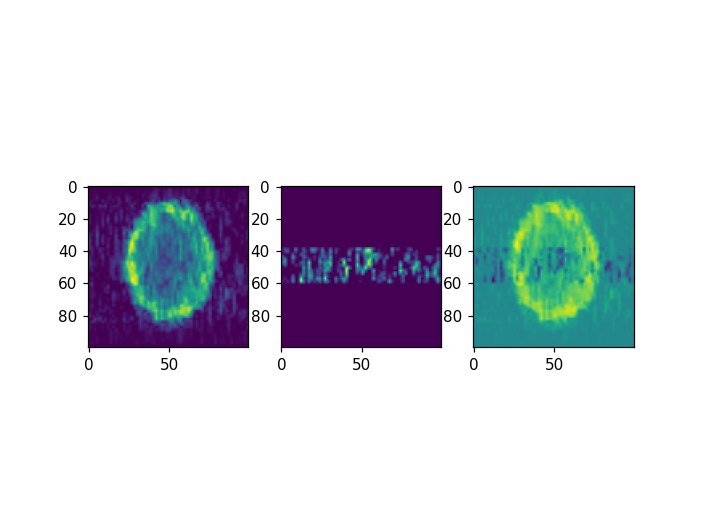

tensor(0)
tensor(1946.3345)


In [27]:
import matplotlib.pyplot as plt

idx = 0
fig, axes = plt.subplots(1,3)
idx = 30
B = next(enumerate(data_loader))[1]
axes[0].imshow(B[0][idx,:].view(100,-1))
axes[1].imshow(train_np[idx,:].reshape(100,-1))
axes[2].imshow(B[0][idx,:].view(100,-1)-train_np[idx,:].reshape(100,-1))
print(B[1][idx])
print(B[0][idx].sum())

<IPython.core.display.Javascript object>


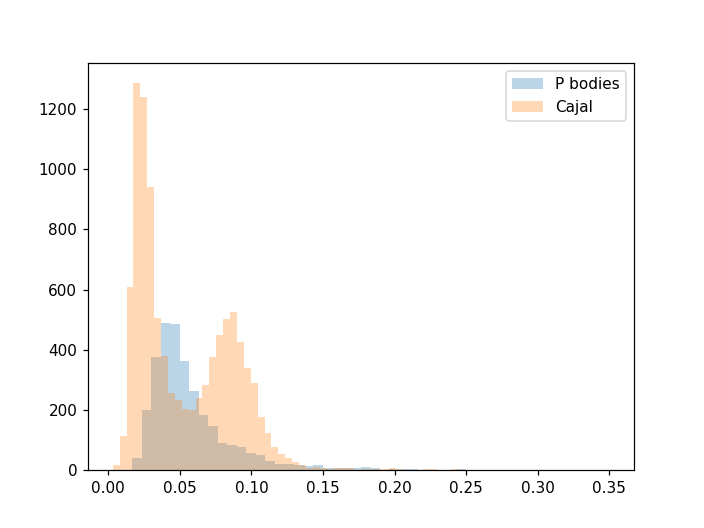

In [48]:
B = next(enumerate(data_loader))[1]
classes = ['cellmask', 'nucleolus', 'centrosome', 'MT', 'cytoplasm', 'ER', 'NE', 'nucleus', 'P bodies', 'Cajal']
id2class = dict(zip(range(10), classes))
ax, fig = plt.subplots(1,1)
for idx, l in enumerate(B[1].unique()[8:10]):
    px_mean = B[0][B[1]==l,:].mean(dim=1)
    plt.hist(px_mean, alpha=0.3, bins=50, label=f"{id2class[l.item()]}")
plt.legend()

# Check nonlinearity

<IPython.core.display.Javascript object>


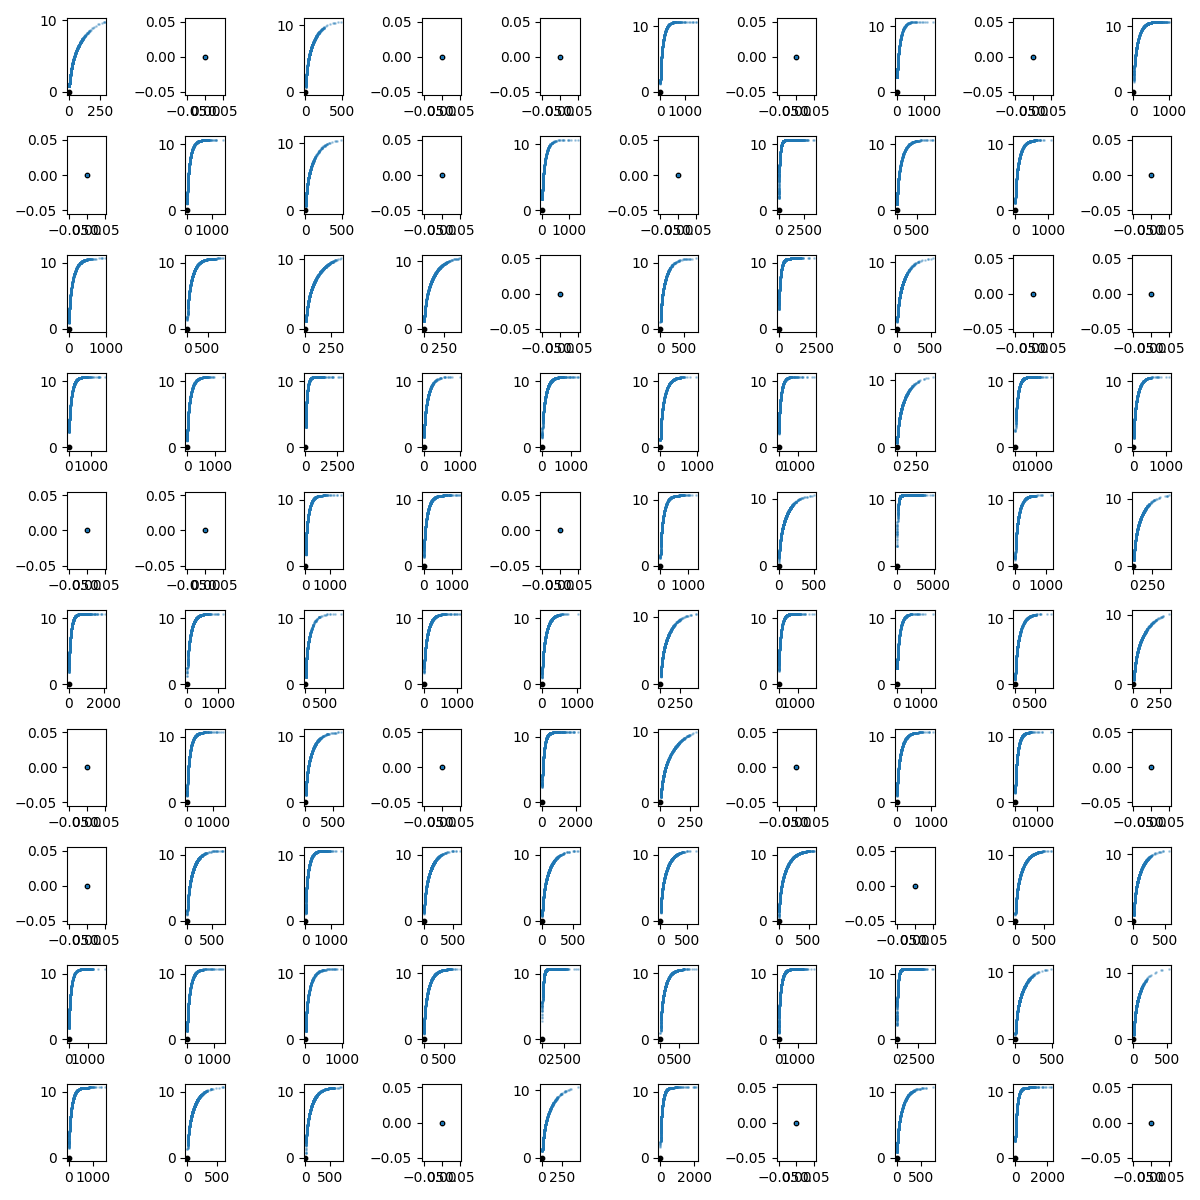

In [131]:
from scipy.optimize import curve_fit

def func2(x, b, c, d, e):
    return (-1.*b*np.exp(-c*x) - d*np.exp(-e*x) + b + d)

coeffs_refit = np.load('./Nonlinearity_Curves_April_8_data_refit.npz')['coeffs']

fig, axes = plt.subplots(10, 10, figsize = (12, 12))
x0 = torch.arange(0, 400/10, 0.1)
# y0s = model.encoder_nn[1](x0.tile(100,1).T)
# p0s = np.ones((36,4))
# p0s[0,:] = [20, 4, 0, 10]
# p0s[3,:] = [10, 1/3, 1, 1]
# p0s[5,:] = [20, 1/3, 1, 1]
# p0s[8,:] = [100, 1/100, 0, 1]
# p0s[12,:] = [10, 1/2, 0, 1]
# p0s[19,:] = [10, 1/2, 0, 1]
# p0s[23,:] = [20, 1/2, 0, 1]
# p0s[33,:] = [10, 1/2, 0, 1]
# p0s[35,:] = [20, 1/2, 0, 1]
# p0s[:,1] = p0s[:,1]/100
# p0s[:,3] = p0s[:,3]/100
# T1_inv = lambda x: (x+7843.875)/2986.897
# T2_inv = lambda x: x/156575.98
# coeffs_new = np.zeros(p0s.shape)
for k in range(100):
    i = k//10
    j = k%10
    ax = axes[i,j]
#     ax.plot(x0, y0s[:,k], 'r')
    ax.scatter(0, 0, s=10, c='k')
    x = hkfc1.output[:,k].detach().numpy()
#     y = model.encoder_nn[1](hkfc1.output[:,k]).detach().numpy()
    y = hkact1.output[:,k].detach().numpy()
    ax.scatter(x, y, s=1, alpha=0.3)
#     ax.set_xlabel('Input Intensity')
#     ax.set_ylabel('Output Intensity')
#     popt, _ = curve_fit(func2, x, y, p0=p0s[k,:], maxfev=5000)
#     print(popt)
#     coeffs_new[k,:] = popt
#     coeffs_new[k,0] = coeffs_new[k,0]*50
#     coeffs_new[k,2] = coeffs_new[k,2]*50
#     ax.plot(x0, func2(x0, *coeffs_new[k,:])/50, 'r--')
#     ax.plot(x0, func2(x0, *coeffs_orig[k,:])/50, 'b')
    

        #ax[i, j].set_xticks([])
        #ax[i, j].set_yticks([])
#plt.savefig('Old_intensifier_nonlinearity', dpi = 1200)
plt.tight_layout()
plt.show()

# Test Runs

In [15]:
b = next(enumerate(test_loader))[1][0].cuda()
x = model.bn1(x)
x = model.relu(x)
x = model.conv2(x)
x = model.bn1(x)
x = model.relu(x)
x = model.meanpool(x)

In [64]:
b = next(enumerate(test_loader))[1][0].cuda()
x = model.conv1(b.reshape(-1, 1, 100, 100))
x = model.backbone(x)

In [59]:
model.conv1

(Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),)

In [ ]:
args.wandb = True

# model = digitalClassifier([100**2, 1000, 500, 10])
model = ConvClassifier3([100**2, 200, 10])

# with torch.no_grad():
#     model.encoder_nn[0].W_Opt.copy_(torch.tensor(H1/3.2))
#     model.encoder_nn[2].W_Opt.copy_(torch.tensor(H2/10))
#     model.encoder_nn[4].W_Opt.copy_(torch.tensor(H3/10))
    
# model.encoder_nn[0].W_Opt.requires_grad = False
# model.encoder_nn[2].W_Opt.requires_grad = False
# model.encoder_nn[4].W_Opt.requires_grad = False

if args.cuda:
    torch.cuda.set_device(0)
    model.cuda() # transfer the model from cpu to gpu
    
if args.wandb:
    wandb.init(project="Jun_16_fullcell_class", name="Conv2_full_200_40_b128_AdamW_lr_0.0008_beta_0.99_0.999", reinit=True)
    wandb.watch(model, log="all")

# Configure loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=8E-4, betas=(0.999, 0.999), weight_decay=0e-4)

# Loop around epoches
train_loader.batch_sampler.batch_size = 128
for epoch in range(1, 300):
#     if epoch > 3000:
#          model.encoder_nn[0].W_Opt.requires_grad = True
    train(epoch, model, optimizer, criterion, train_loader)
    loss = test(epoch, model, criterion, val_loader)

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇███████████████████████████
batch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▆▄▃▆▄▇▂▅▃▃▃▂▂▃▂▄▂▂▅▃▁▂▂▂▂▂▂▂▂▂▁▂▂▃▂▁▁▃
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,89.24989
batch,436
train_loss,0.55076
val_loss,0.36551


Train Epoch: 1 		Loss: 1.427384	Accuracy:  24.05%

Test set: Epoch 1, Average loss: 1.7464, Accuracy: 9332/27916(33%)

Train Epoch: 2 		Loss: 1.428649	Accuracy:  39.93%

Test set: Epoch 2, Average loss: 1.5210, Accuracy: 13211/27916(47%)

Train Epoch: 3 		Loss: 1.735132	Accuracy:  50.05%

Test set: Epoch 3, Average loss: 1.3854, Accuracy: 14526/27916(52%)

Train Epoch: 4 		Loss: 1.445472	Accuracy:  53.34%

Test set: Epoch 4, Average loss: 1.2913, Accuracy: 15214/27916(54%)

Train Epoch: 5 		Loss: 1.243447	Accuracy:  56.57%

Test set: Epoch 5, Average loss: 1.2289, Accuracy: 16318/27916(58%)

Train Epoch: 6 		Loss: 1.424465	Accuracy:  59.51%

Test set: Epoch 6, Average loss: 1.1624, Accuracy: 17297/27916(62%)

Train Epoch: 7 		Loss: 1.258153	Accuracy:  62.76%

Test set: Epoch 7, Average loss: 1.1059, Accuracy: 18073/27916(65%)

Train Epoch: 8 		Loss: 1.337803	Accuracy:  65.11%

Test set: Epoch 8, Average loss: 1.0625, Accuracy: 18406/27916(66%)

Train Epoch: 9 		Loss: 0.956853	Accuracy:

# Test model

In [103]:
%matplotlib notebook

In [20]:
model = ConvClassifier([100**2, 200, 10])
model_ckpt = torch.load("./Conv1_ch16_200_10_b256_AdamW_lr_0.002414_betas_0.9964_0.9994_swa_60_0.0002_v_43/ep222.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


FileNotFoundError: [Errno 2] No such file or directory: './Conv1_ch16_200_10_b256_AdamW_lr_0.002414_betas_0.9964_0.9994_swa_60_0.0002_v_43/ep222.pt'

In [130]:
import matplotlib.pyplot as plt

model.cpu()
B = next(enumerate(test_loader))[1]
test_images = B[0].to(device="cpu")
test_labels = B[1]
pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
accuracy = 100. * correct / len(test_labels)
print(correct, accuracy)

tensor(899) tensor(89.9000)


# Plots

In [69]:
%matplotlib notebook

<IPython.core.display.Javascript object>


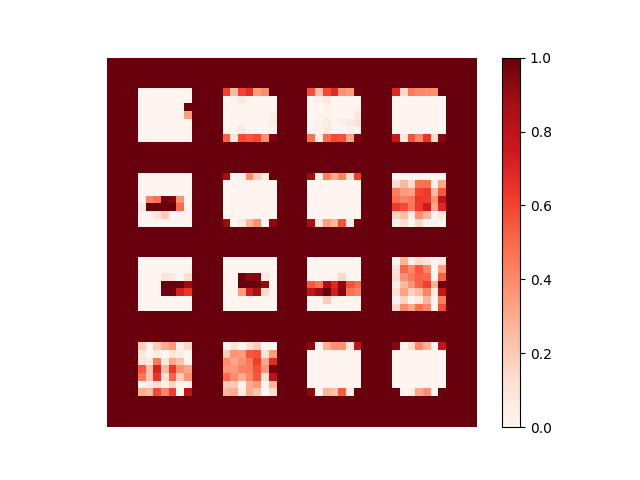

In [129]:
import torchvision
import matplotlib.pyplot as plt

W = model.conv1.conv2d.weight.to(device='cpu')
W = W.view(16,1,7,7)
W = W.repeat(1,3,1,1)
W_vis = torchvision.utils.make_grid(W, padding=4, pad_value=1, nrow=4)
plt.figure()
plt.imshow(W_vis[0,:,:].detach().numpy(), cmap="Reds")
plt.axis("off")
plt.colorbar()
plt.show()
#plt.savefig(f"./figures/publish/fcs_0_weights.svg", dpi=300, format="svg")

<IPython.core.display.Javascript object>


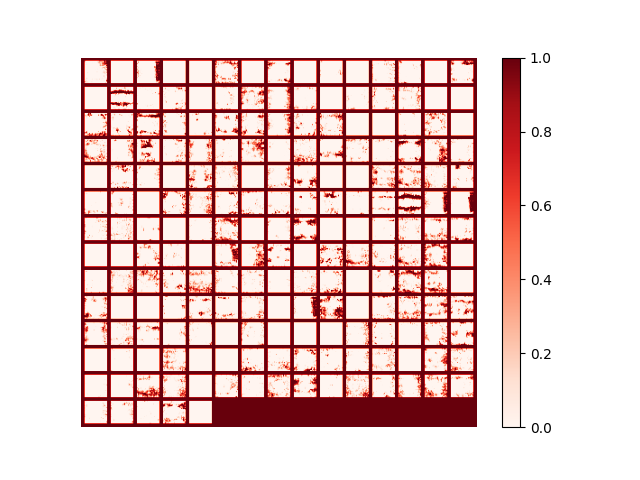

In [135]:
import torchvision
import matplotlib.pyplot as plt

W = model.l1.W_Opt.to(device='cpu')
W = W.view(-1,16,25,25)
W = W.repeat(1,3,1,1)
W_vis = torchvision.utils.make_grid(W, padding=4, pad_value=1, nrow=15)
plt.figure()
plt.imshow(W_vis[0,:,:].detach().numpy(), cmap="Reds")
plt.axis("off")
plt.colorbar()
plt.show()
#plt.savefig(f"./figures/publish/fcs_0_weights.svg", dpi=300, format="svg")

<IPython.core.display.Javascript object>


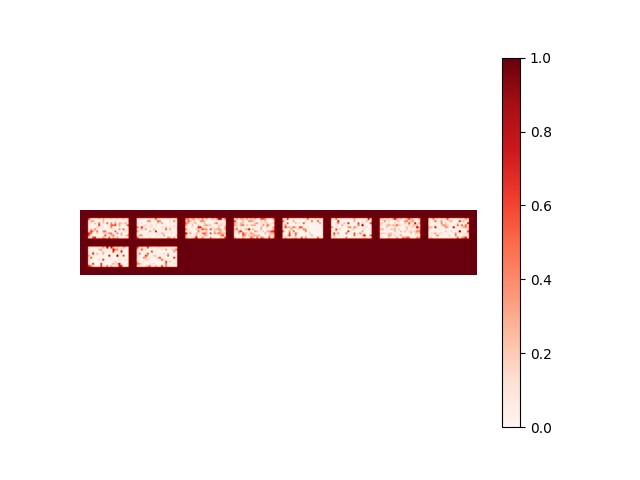

In [136]:
import torchvision

W = model.l2.W_Opt.to(device='cpu')
W = W.view(-1,1,10,20)
W = W.repeat(1,3,1,1)
W_vis = torchvision.utils.make_grid(W, padding=4, pad_value=1, nrow=8)
plt.figure()
plt.imshow(W_vis[0,:,:].detach().numpy(), cmap="Reds")
plt.axis("off")
plt.colorbar()
plt.show()
#plt.savefig(f"./figures/publish/fcs_0_weights.svg", dpi=300, format="svg")

In [33]:
print(torch.__version__, optuna.__version__, ray.__version__)

1.11.0+cu102 1.5.0 1.11.0
